In [12]:
import pandas as pd
import numpy as np

df = pd.read_csv('master_data.csv', index_col = 0)
df.reset_index(drop=True, inplace=True)
del df['distance_intraelevation_intra']
days = df['date'].unique()
df['steps_rolling_sum'] = df['steps_intra']

for day in days:
    df.loc[df['date'] == day, 'steps_rolling_sum'] = df.loc[df['date'] == day, 'steps_intra'].cumsum()
    df.loc[df['date'] == day, 'calories_rolling_sum'] = df.loc[df['date'] == day, 'calories_intra'].cumsum()
    df.loc[df['date'] == day, 'floors_rolling_sum'] = df.loc[df['date'] == day, 'floors_intra'].cumsum()
        

df.to_csv('master_data_2.csv', index=False)

In [34]:
df['steps_goal'] = df['steps_day'].median()
#display(list(df.columns))

In [39]:
#insert calendar data
calendar_data = pd.read_csv("calendar.csv")
calendar_data[:]

,Date,Hours
0,2018-08-10,3.5
1,2018-08-11,3.5
2,2018-08-12,0.5
3,2018-08-13,1.0
4,2018-08-14,0.0
5,2018-08-15,0.0
6,2018-08-16,0.0
7,2018-08-17,0.0
8,2018-08-18,0.0
9,2018-08-19,0.0


In [40]:
for date in calendar_data['Date']:
    df.loc[df['date'] == date, "Duration"] = calendar_data.loc[calendar_data['Date']==date, 'Hours'].values
df_2 = df

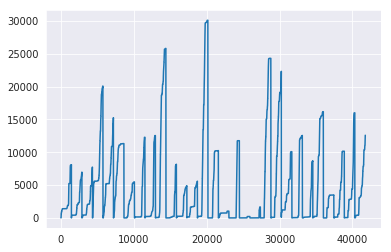

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.plot(df['steps_rolling_sum'])
plt.show()

In [42]:
df['steps_goal_reached'] = False
df.loc[df['steps_day'] > df['steps_goal'], 'steps_goal_reached'] = True

In [49]:
from sklearn import tree
from sklearn.model_selection import train_test_split

np.random.seed(0)
df = df.dropna(axis=1)

msk = np.random.rand(len(df)) < 0.8
train = df[msk].copy()
test = df[~msk].copy()

y_train = train['steps_goal_reached']
X_train = train
time_ = [sum(i*j for i, j in zip(map(int, ti.split(':')), [60, 1, 1/60])) for ti in X_train['time_intra'].values] 
X_train['mins_in_day'] = time_
import time
dow = [time.strftime("%A", time.strptime(date, "%Y-%m-%d")) for date in list(X_train['date'].values)]
#display(dow)
import calendar
d=dict(enumerate(calendar.day_name))
#display(d)
X_train = X_train[['mins_in_day','steps_rolling_sum', 'Duration']]



y_test = test['steps_goal_reached']
X_test = test
time_ = [sum(i*j for i, j in zip(map(int, ti.split(':')), [60, 1, 1/60])) for ti in X_test['time_intra'].values] 
X_test['mins_in_day'] = time_
X_test = X_test[['mins_in_day','steps_rolling_sum', 'Duration']]



clf = tree.DecisionTreeClassifier(max_depth=10,min_samples_split=200)
clf.fit(X=X_train, y=y_train)
#display(zip(list(X_train.columns),clf.feature_importances_)) # 
print("Accuracy for Decision Trees = ", clf.score(X=X_test, y=y_test ))



Accuracy for Decision Trees =  0.946066066066


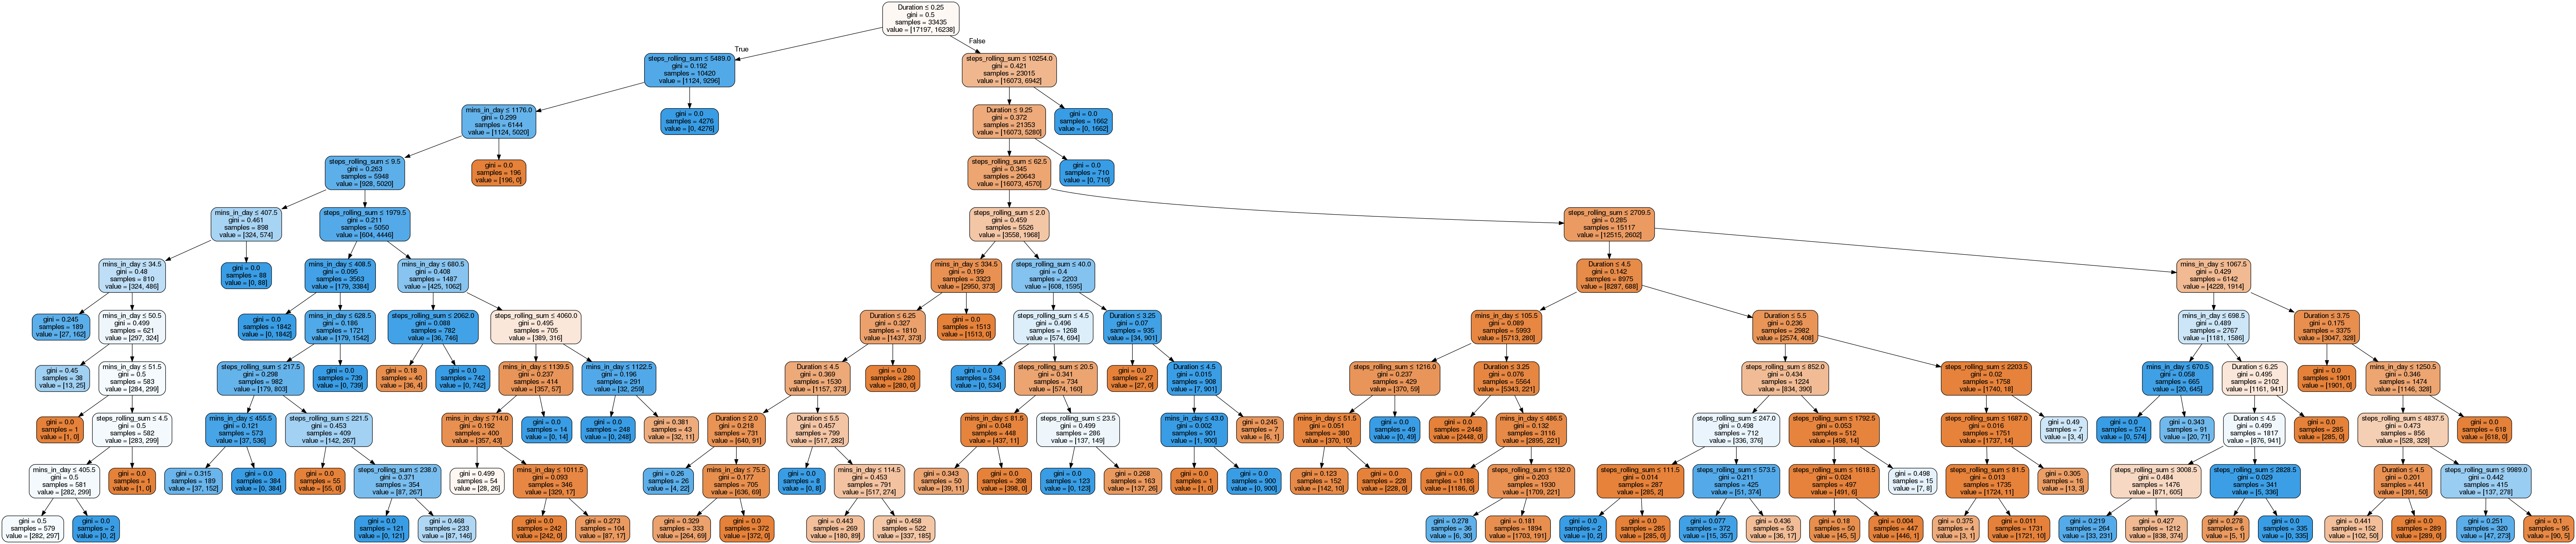

In [19]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
               feature_names=list(X_train.columns))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [53]:
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression()
clf2.fit(X=X_train, y=y_train)
print("Accuracy of Logistic Regression: = ",(clf2.score(X=X_test, y=y_test )))
print("Coeff for Logistic Regression: = ", clf2.coef_)

Accuracy of Logistic Regression: =  0.723243243243
Coeff for Logistic Regression: =  [[-0.00160871  0.00030867 -0.08755563]]


In [55]:
thresh_train = list((df['steps_day'].median()/float(X_train['mins_in_day'].max())*X_train['mins_in_day']).values)
# thresh_test = list((df['steps_day'].median()/float(X_test['mins_in_day'].max())*X_test['mins_in_day']).values)

pred = [True if rolling >= thresh else False for rolling,thresh in zip(list(X_train['steps_rolling_sum'].values),thresh_train)]

acc = [1 if pr == actual else 0 for pr, actual in zip(pred, y_train)]

print('Baseline Accuracy =', sum(acc)/float(len(acc)))

Baseline Accuracy = 0.6980708838043966


In [57]:
from sklearn.ensemble import RandomForestRegressor
# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=50)

# Train the model on training data
rf.fit(X_train, y_train);
print("Accuracy for Random Forest = ",rf.score(X_test, y_test))

Accuracy for Random Forest =  0.890998094236


In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=1000, max_samples=0.8,
                        random_state=1)
bag.fit(X_train, y_train)
print("Accuracy for Ensemble methods = ", bag.score(X_test,y_test) )

Accuracy for Ensemble methods =  0.964444444444


In [59]:
df.describe()

,steps_intra,calories_intra,floors_intra,steps_day,calories_day,distance_day,distance_intra,elevation_day,elevation_intra,floors_day,steps_rolling_sum,calories_rolling_sum,floors_rolling_sum,steps_goal,Duration
count,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.000000,41760.0,41760.000000
mean,8.038554,1.996647,0.025287,11578.206897,2875.689655,5.046897,0.003499,364.137931,0.252874,36.413793,4260.952299,1292.264538,14.025455,10249.0,3.017241
std,24.910310,1.831513,0.241887,7307.091533,602.189168,3.296650,0.011507,403.921158,2.418873,40.392116,6143.132985,942.842803,30.911727,0.0,2.820778
min,0.000000,1.192000,0.000000,215.000000,1767.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,1.192000,0.000000,10249.0,0.000000
25%,0.000000,1.192000,0.000000,6973.000000,2507.000000,2.730000,0.000000,70.000000,0.000000,7.000000,133.000000,508.221750,0.000000,10249.0,0.000000
50%,0.000000,1.201000,0.000000,10249.000000,2764.000000,4.610000,0.000000,270.000000,0.000000,27.000000,1297.500000,1101.324500,1.000000,10249.0,3.500000
75%,0.000000,1.550000,0.000000,15258.000000,3136.000000,6.590000,0.000000,410.000000,0.000000,41.000000,5711.250000,1948.442500,17.000000,10249.0,5.000000
max,176.000000,23.299000,10.000000,30106.000000,4094.000000,14.030000,0.267000,2000.000000,100.000000,200.000000,30106.000000,4093.778000,200.000000,10249.0,11.000000
